# Flight Delay Project - Exploratory Data Analysis

This notebook is primarily focused on data exploration and analysis of the "landed_df" dataframe that was cleaned in the Data_Cleaning notebook.

I will gather and utilise information from outside the dataset in order to better explain the variations in the data.

I will also use data visualisation and statistical analysis in order to understand the dataset.

### The Aim of This Notebook Is To:
- Gain a strong understanding of the data, and the reasons for the variations in the arrival delay of flights.
- Extract meaningful insights that have real world implications.
- Inform the feature selection for the following notebook: Flight_Predictions.


# Step 1: Variations in the Data
The variable I will try to predict is "ARRIVAL_DELAY" which is how many minutes the flight arrived at the airport after it was scheduled to arrive.  It does not describe the time when the flight lands, that is "WHEELS_ON", and so includes the time to taxi from the runway to the terminal.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading in the data
landed_df = pd.read_pickle("landed_flights.pkl")
airlines_df = pd.read_csv("data/airlines.csv")
airports_df = pd.read_csv("data/airports.csv")

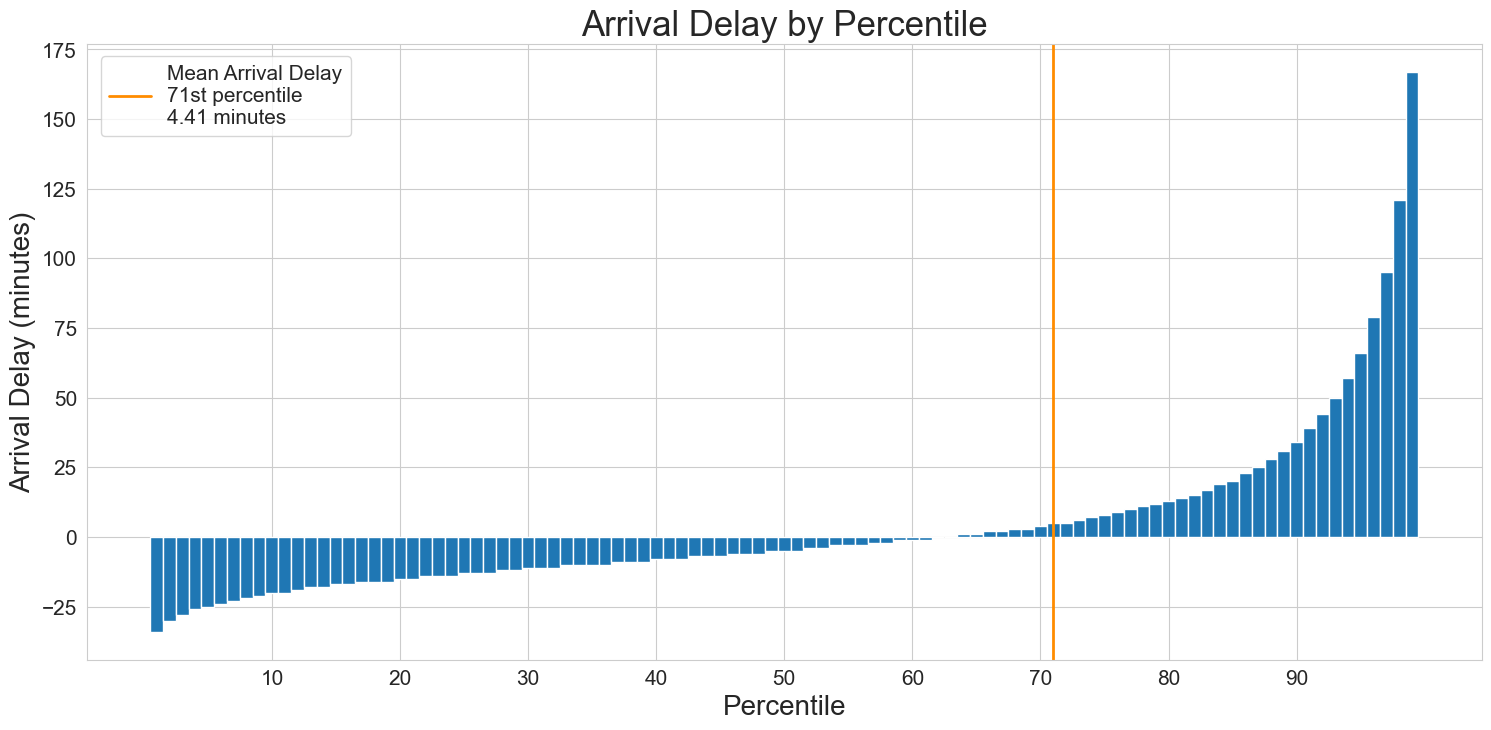

In [141]:
percentiles = np.arange(0.01, 1.0, 0.01)

values = landed_df["ARRIVAL_DELAY"].quantile(percentiles)

# Finding the percentile of the mean.
vert_line = percentiles[np.argmax(values >= landed_df["ARRIVAL_DELAY"].mean())]

plt.figure(figsize=(18,8))
plt.bar(percentiles, values, width=0.01)
plt.axvline(x=vert_line,
            color="darkorange",
            linewidth=2,
            label=f"Mean Arrival Delay\n{vert_line * 100:.0f}st percentile\n{landed_df['ARRIVAL_DELAY'].mean():.2f} minutes")

plt.title("Arrival Delay by Percentile", size=25)
plt.xlabel("Percentile", size=20)
plt.xticks(np.arange(0.1,1,0.1), labels=range(10,100,10), size=15)
plt.ylabel("Arrival Delay (minutes)", size=20)
plt.yticks(size=15)
plt.legend(fontsize=15, loc=(0.01,0.85))

plt.show()

The target variable "ARRIVAL_DELAY" does not follow a normal distribution and has a disproportionate amount of long delays which causes the mean to occupy the 71st percentile.

We can also see that the majority (61%) of flights actually arrive early even though the mean flight delay is around 4 and a half minutes.

### Departure and Arrival Time and Date
Exploring whether the time and date that a flight departs (and arrives) on affects the arrival delay.

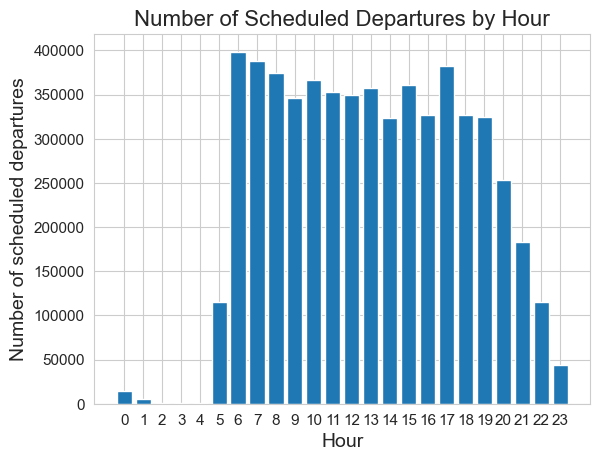

In [4]:
plt.bar(list(range(24)), landed_df.groupby("SCHEDULED_DEPARTURE_HOURS").size())

plt.title("Number of Scheduled Departures by Hour", size=16)
plt.xlabel("Hour", size=14)
plt.xticks(range(24), size=11)
plt.ylabel("Number of scheduled departures", size=14)
plt.yticks(size=11)

plt.show()

Departures are fairly evenly spread throughout the daytime, with very few in the early hours of the morning, a rapid increase after 4am, a peak at 6 and 7am before slowly declining throughout the day and declining from 7pm onwards.

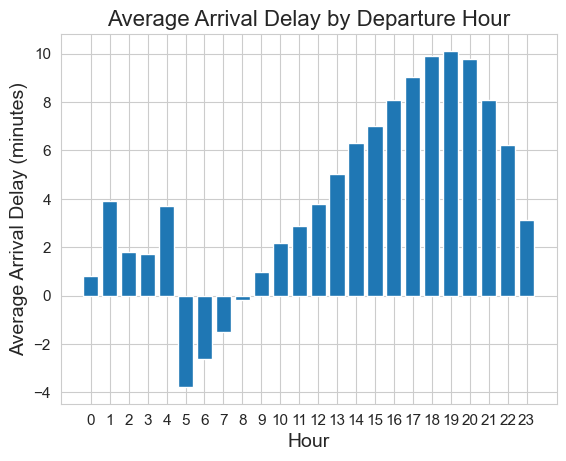

In [5]:
plt.bar(list(range(24)), landed_df.groupby("SCHEDULED_DEPARTURE_HOURS")["ARRIVAL_DELAY"].mean())

plt.title("Average Arrival Delay by Departure Hour", size=16)
plt.xlabel("Hour", size=14)
plt.xticks(range(24), size=11)
plt.ylabel("Average Arrival Delay (minutes)", size=14)
plt.yticks(size=11)

plt.show()

There is a clear trend from 5am until 7pm that flights taking off earlier in the day are have a lower average delay than flights leaving later in the day.

Just as the number of departing flights decreases from 7pm onwards, so does the arrival delay of these flights.

This indicates that throughout the day, many different smaller delays accumulate.  It could be that a delayed flight at 8am might cause the following flights at the same origin airport to be delayed as well.

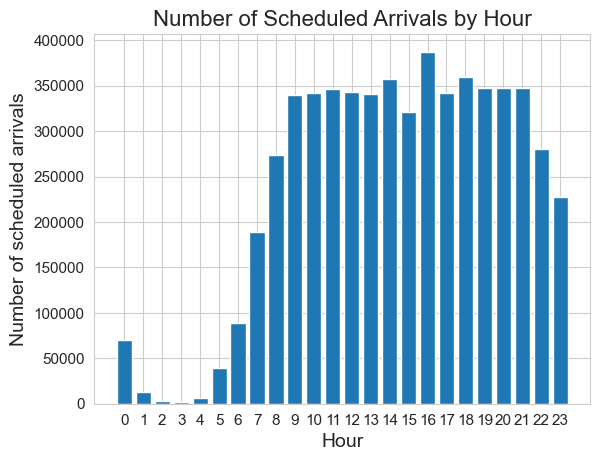

In [6]:
plt.bar(list(range(24)), landed_df.groupby("SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE").size().drop(24))

plt.title("Number of Scheduled Arrivals by Hour", size=16)
plt.xlabel("Hour", size=14)
plt.xticks(range(24), size=11)
plt.ylabel("Number of scheduled arrivals", size=14)
plt.yticks(size=11)

plt.show()

We can see that flights are more likely to arrive in the night than they are to depart in the night.  The inverse pattern is true for the morning.

Between around 9am to 10pm, the number of arrivals is very steady.

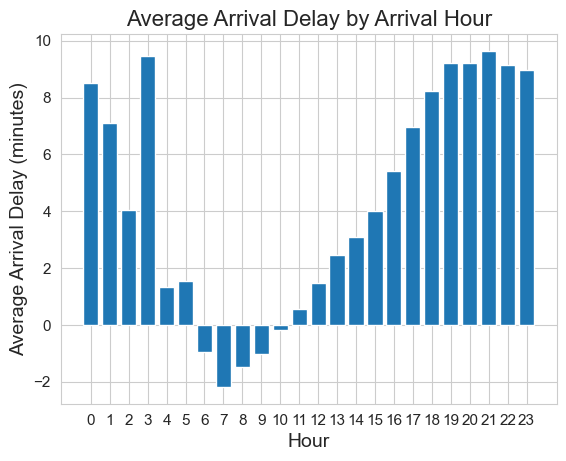

In [7]:
plt.bar(list(range(24)), landed_df.groupby("SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE")["ARRIVAL_DELAY"].mean().drop(24))

plt.title("Average Arrival Delay by Arrival Hour", size=16)
plt.xlabel("Hour", size=14)
plt.xticks(range(24), size=11)
plt.ylabel("Average Arrival Delay (minutes)", size=14)
plt.yticks(size=11)

plt.show()

Just like how the "Number of Scheduled Arrivals by Hour" chart showed the same underlying patter,n but with a several hour time shift, as "Number of Scheduled Departures by Hour", so does "Average Arrival Delay by Arrival Hour" with "Average Arrival Delay by Departure Hour"

We can also see that flights arriving in the early hours of the morning (1am to 3am) have a notably larger average arrival delay than flights departing at that time.  This might be because there are fewer flights that are scheduled to arrive at these times and so a disproportionate amount of flights actually arriving at these times were delayed from earlier in the night.

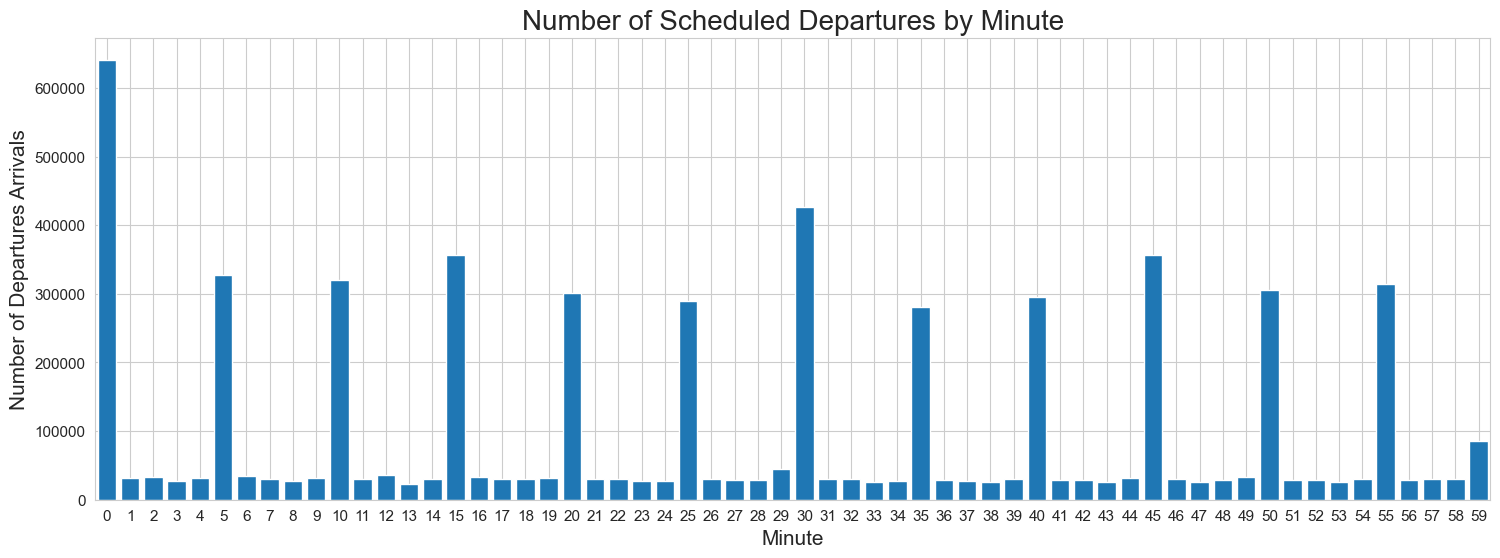

In [144]:
plt.figure(figsize=(18,6))

plt.bar(list(range(60)), landed_df.groupby("SCHEDULED_DEPARTURE_MINUTES").size())

plt.title("Number of Scheduled Departures by Minute", size=20)
plt.xlabel("Minute", size=15)
plt.xticks(range(60), size=11)
plt.xlim([-0.5, 59.5])
plt.ylabel("Number of Departures Arrivals", size=15)
plt.yticks(size=11)

plt.show()

We can see that flights are most commonly scheduled on the hour, then at minutes that are multiples of 5.


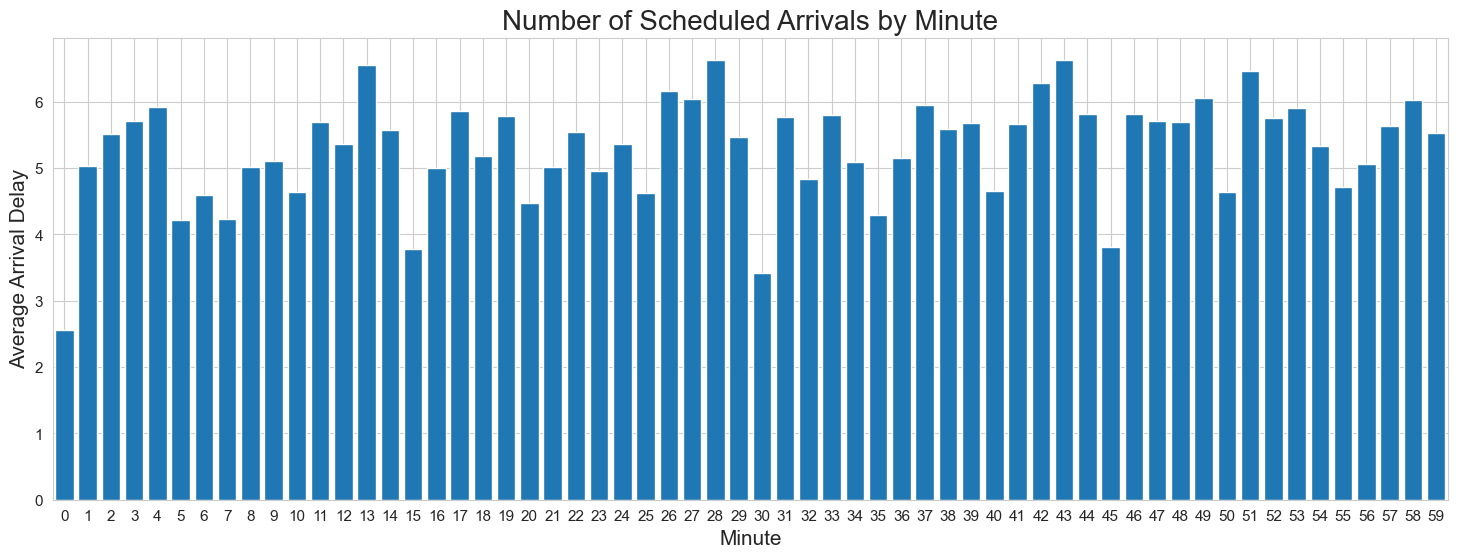

In [143]:
plt.figure(figsize=(18,6))

plt.bar(list(range(60)), landed_df.groupby("SCHEDULED_DEPARTURE_MINUTES")["ARRIVAL_DELAY"].mean())

plt.title("Number of Scheduled Arrivals by Minute", size=20)
plt.xlabel("Minute", size=15)
plt.xticks(range(60), size=11)
plt.ylabel("Average Arrival Delay", size=15)
plt.yticks(size=11)
plt.xlim([-0.5, 59.5])
plt.show()

Flights that are scheduled to depart on: the hour, half hour, quarter past, and quarter to, have a lower average arrival delay than flights departing at other times.

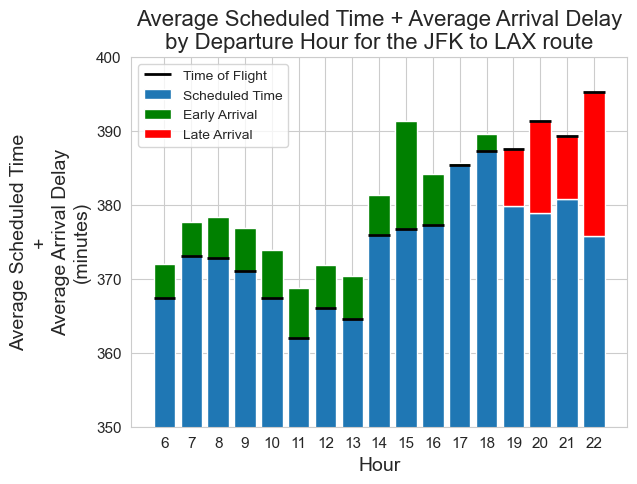

In [10]:
# Collecting the mean SCHEDULED_TIME and ARRIVAL_DELAY for flights departing from JFK and arriving in LAX.
jfk_lax_by_hour_df = (landed_df.groupby(["ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "SCHEDULED_DEPARTURE_HOURS"])
                      .agg({"SCHEDULED_TIME":"mean", "ARRIVAL_DELAY":"mean", "MONTH":"count"})
                      .reset_index()
                      .set_index(["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])
                      .loc["JFK", "LAX"]
                      .rename({"MONTH": "NUMBER_OF_FLIGHTS"}, axis=1)
                      .dropna())

plt.bar(list(range(17)), jfk_lax_by_hour_df["SCHEDULED_TIME"],
        label="Scheduled Time")

label_red = True
label_green = True

for departure, schedule, delay in zip(jfk_lax_by_hour_df["SCHEDULED_DEPARTURE_HOURS"] - 6,
                                      jfk_lax_by_hour_df["SCHEDULED_TIME"],
                                      jfk_lax_by_hour_df["ARRIVAL_DELAY"]):

    label1 = None
    label2 = None
    if delay <= 0 and label_green:
        label1 = "Early Arrival"
        label_green = False
        label2 = "Time of Flight"
    elif delay >= 0 and label_red:
        label1 = "Late Arrival"
        label_red = False

    plt.bar(departure, delay, bottom=schedule,
            label=label1,
            color="green" if delay <= 0 else "red")

    plt.hlines(schedule + delay, departure - 0.4, departure + 0.4,
               label=label2,
               color="black",
               linewidth=2)

plt.title("Average Scheduled Time + Average Arrival Delay\nby Departure Hour for the JFK to LAX route", size=16)
plt.xlabel("Hour", size=14)
plt.xticks(range(0,17,1), labels=range(6,23,1), size=11)
plt.ylabel("Average Scheduled Time\n+\nAverage Arrival Delay\n(minutes)", size=14)
plt.yticks(size=11)
plt.ylim(350, 400)
plt.legend()

plt.show()

Flights departing earlier in the day, on average, arrive earlier than scheduled, whereas flights departing in the evening, on average, arrive later than scheduled.  This roughly matches up with my previous analysis.

However, for this route, flights departing before 2pm have a shorter scheduled time than flights arriving later.  This indicates that airlines are already taking account of the fact that flights arriving later in the day have longer average delays.

The average flight at 11am and 4pm have very similar arrival delays but the flight at 11am arrives around 15 minutes earlier because of its shorter scheduled time.

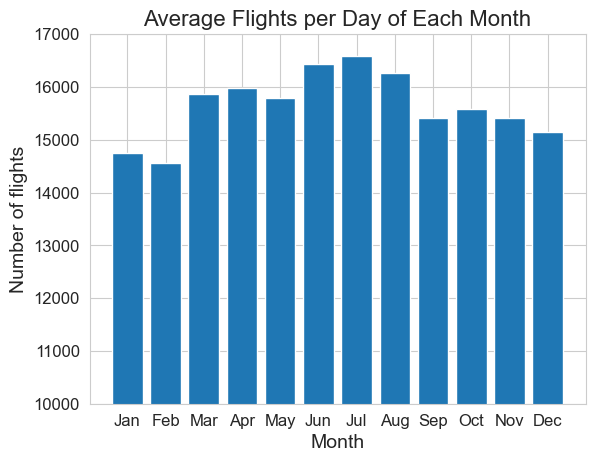

In [11]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.bar(months, landed_df.groupby("MONTH").size() / [31,28,31,30,31,30,31,31,30,31,30,31]) # Different months have different numbers of days in them, so I am calculating the average flights per day rather than just the average flights per month.

plt.title("Average Flights per Day of Each Month", size=16)
plt.xlabel("Month", size=14)
plt.xticks(size=12)
plt.ylim(10000, 17000)
plt.ylabel("Number of flights", size=14)
plt.yticks(size=12)

plt.show()

The summer months have the most flights per day whilst January and February have the least.

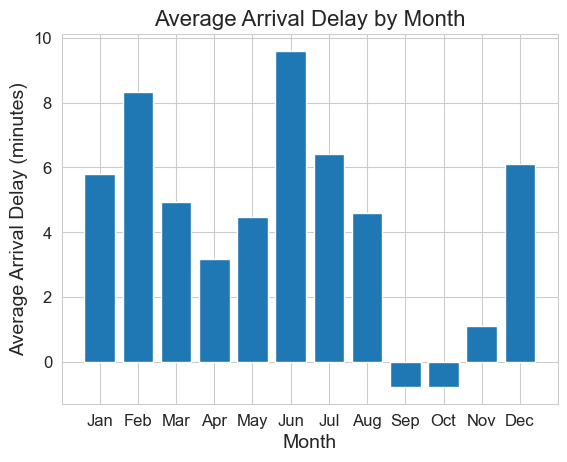

In [12]:
plt.bar(months, landed_df.groupby("MONTH")[["ARRIVAL_DELAY"]].mean()["ARRIVAL_DELAY"])

plt.title("Average Arrival Delay by Month", size=16)
plt.xlabel("Month", size=14)
plt.xticks(size=12)
plt.ylabel("Average Arrival Delay (minutes)", size=14)
plt.yticks(size=12)

plt.show()

The autumn months of September, October and November have the shortest average arrival delays.

June has the longest average delays followed by February.

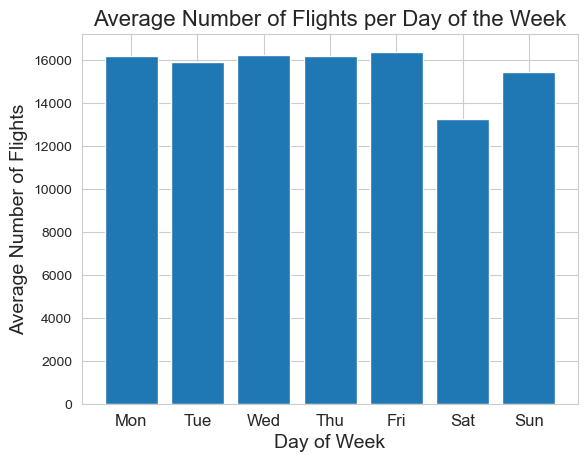

In [13]:
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

landed_indexed_by_days_df = landed_df.set_index(["MONTH", "DAY", "DAY_OF_WEEK"])

occurrences_of_each_day_of_week = np.array(landed_indexed_by_days_df
                                           [~landed_indexed_by_days_df.index.duplicated()]
                                           .reset_index()
                                           ["DAY_OF_WEEK"]
                                           .value_counts()
                                           .sort_index())

plt.bar(days, landed_df.groupby("DAY_OF_WEEK").size() / occurrences_of_each_day_of_week)  # Thursday occurred 53 times

plt.title("Average Number of Flights per Day of the Week", size=16)
plt.xlabel("Day of Week", size=14)
plt.xticks(size=12)
plt.ylabel("Average Number of Flights", size=14)
plt.xticks(size=12)

plt.show()

Saturday has the least number of flights per day but there are similar numbers of flights for the other days of the week.

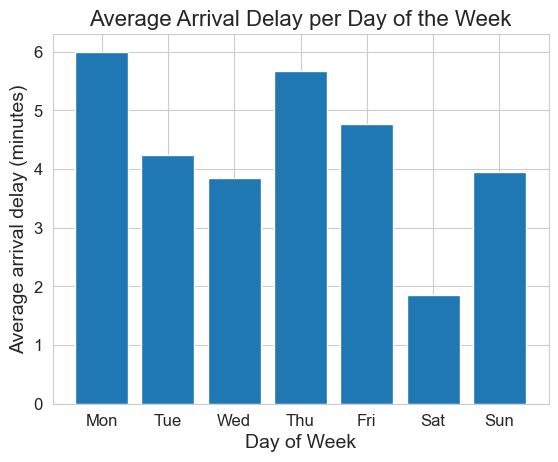

In [14]:
plt.bar(days, landed_df.groupby("DAY_OF_WEEK")[["ARRIVAL_DELAY"]].mean()["ARRIVAL_DELAY"])

plt.title("Average Arrival Delay per Day of the Week", size=16)
plt.xlabel("Day of Week", size=14)
plt.xticks(size=12)
plt.ylabel("Average arrival delay (minutes)", size=14)
plt.yticks(size=12)

plt.show()

The longest average arrival delays are on Monday and Thursday with Saturday having the shortest delays.

Fewer flights on Saturday correlates to there being a lower average arrival delay on Saturday.

### Given Reasons for Delays
The dataset includes 5 different given reasons for a flight being delayed

In [15]:
print(f"Out of {len(landed_df):,} total flights,")

print(f"{(landed_df[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] != 0).sum(axis=1).sum():,} flights were given at least 1 reason for their delay")

print(f"and {len(landed_df) - (landed_df[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']] != 0).sum(axis=1).le(1).sum():,}, were given multiple reasons for their delay.")

Out of 5,714,008 total flights,
1,760,001 flights were given at least 1 reason for their delay
and 571,781, were given multiple reasons for their delay.


In [16]:
((landed_df[["AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]] != 0).sum()
 .rename("Number of Flights Given This Reason for their Delay"))

AIR_SYSTEM_DELAY       564826
SECURITY_DELAY           3484
AIRLINE_DELAY          570022
LATE_AIRCRAFT_DELAY    556953
WEATHER_DELAY           64716
Name: Number of Flights Given This Reason for their Delay, dtype: int64

The most common delays are attributed to the airline, the air system, and late aircraft.

Weather delays occur roughly 9x less than these 3 types, and security delays occur 180x less.

In [17]:
landed_df[["AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].replace(0, np.nan).describe()

,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,564826.000000,3484.000000,570022.000000,556953.000000,64716.000000
mean,25.380846,23.244834,35.389785,44.818739,47.905201
std,34.270152,29.395108,61.206690,51.050839,68.598030
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7.000000,8.000000,8.000000,15.000000,12.000000
50%,17.000000,15.000000,17.000000,28.000000,25.000000
75%,29.000000,26.000000,38.000000,57.000000,57.000000
max,1134.000000,573.000000,1971.000000,1331.000000,1211.000000


When there are delays, Late Aircraft and Weather delays are the longest on average.

The mean of all the features is notably higher than the median.  This implies that the mean is skewed by some very long delays.

We can see that the lower quartiles are all very similar apart from the Late Aircraft delay which has the highest lower quartile, mean, and upper quartile, as well as the largest maximum value.

However, it has a significantly lower standard deviation than both Airline and Weather delays.  This could be because Weather and Airline delays are more likely to have very long delays, and if we look at their 99th percentile, it is larger for both Airline and Weather delays than it is for Late Aircraft delays.

In [18]:
landed_df[["AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].replace(0, np.nan).quantile(0.99).rename("99th Percentile of Delay Time")

AIR_SYSTEM_DELAY       172.00
SECURITY_DELAY         142.34
AIRLINE_DELAY          281.00
LATE_AIRCRAFT_DELAY    241.00
WEATHER_DELAY          317.00
Name: 99th Percentile of Delay Time, dtype: float64

### Analysis of Key Features

In [19]:
column_EDA = ["DEPARTURE_DELAY",
              "TAXI_OUT",
              "DISTANCE",
              "SCHEDULED_TIME",
              "AIR_TIME",
              "TAXI_IN",
              "SCHEDULED_DEPARTURE_MINUTES",
              "SCHEDULED_DEPARTURE_HOURS",
              "SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE",
              "ARRIVAL_DELAY"]

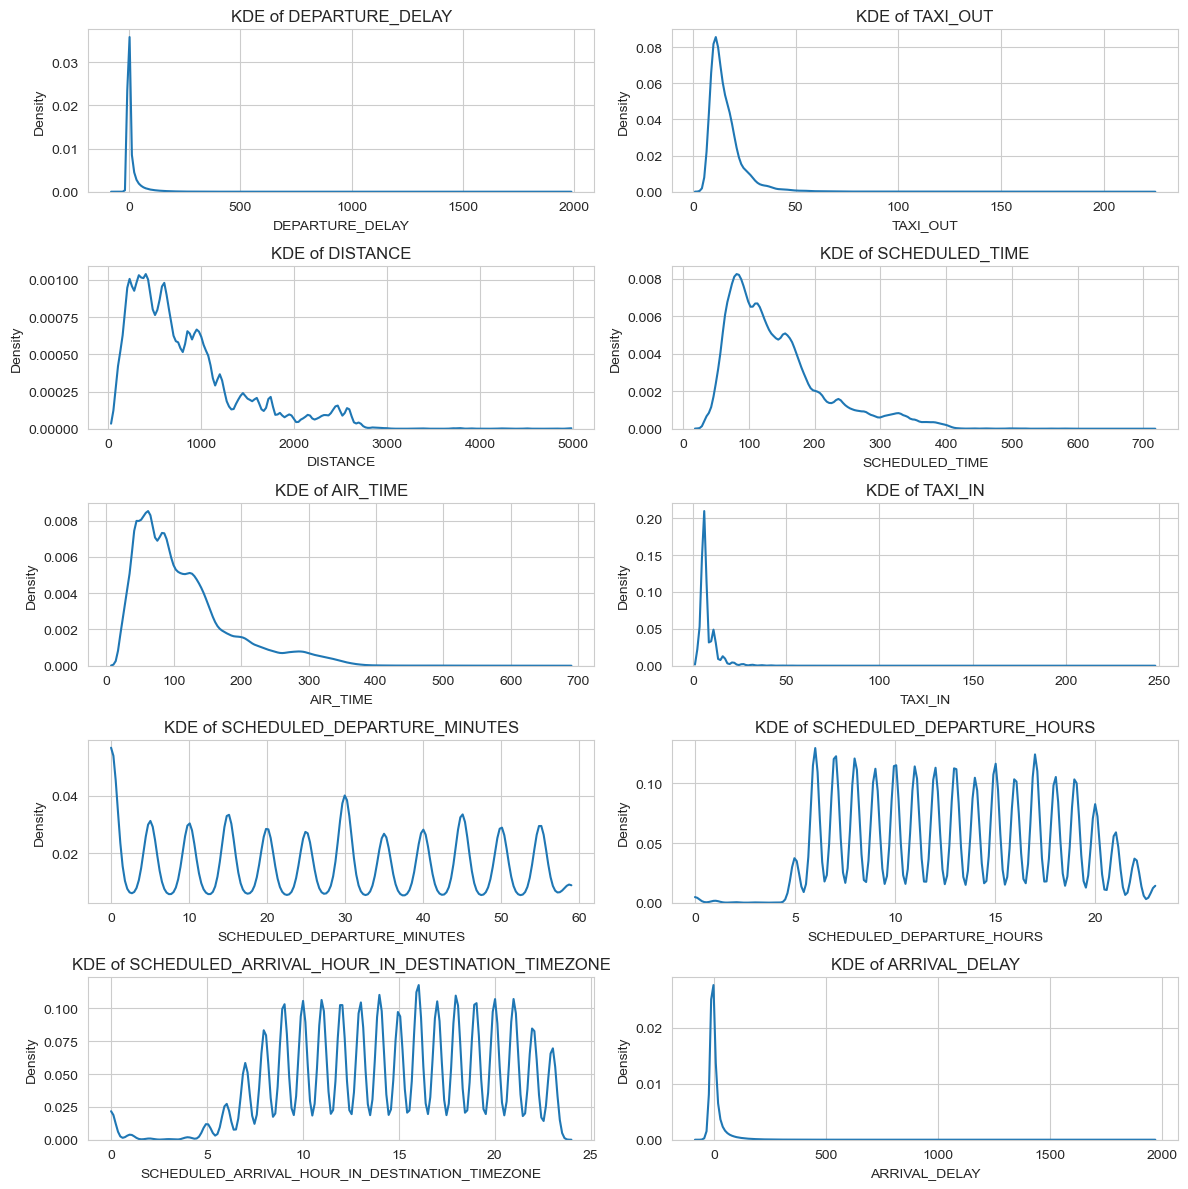

In [55]:
plt.figure(figsize=(12, 12))
for i, column in enumerate(column_EDA, 1):

    plt.subplot(5, 2, i)
    if landed_df[column].dtype == "<M8[ns]":
        sns.kdeplot(landed_df[column].map(lambda x: x.timestamp()),
                                          cut=0,
                                          clip=(landed_df[column].map(lambda x: x.timestamp()).min(), landed_df[column].map(lambda x: x.timestamp()).max()))
    else:
        sns.kdeplot(landed_df[column],
                    cut=0,
                    clip=(landed_df[column].min(), landed_df[column].max()))

    plt.title(f"KDE of {column}")

plt.tight_layout()
plt.show()

The Kernel Density Estimation (KDE) graphs show the variation of the key features.

The density variation of Distance, Scheduled Time and Air Time are very similar, as can be expected given their obvious correlation.

More interesting is that Taxi In has a higher concentration of values than Taxi Out.

The 2 plots showing features in hours use discrete variables and are poorly suited to KDE.

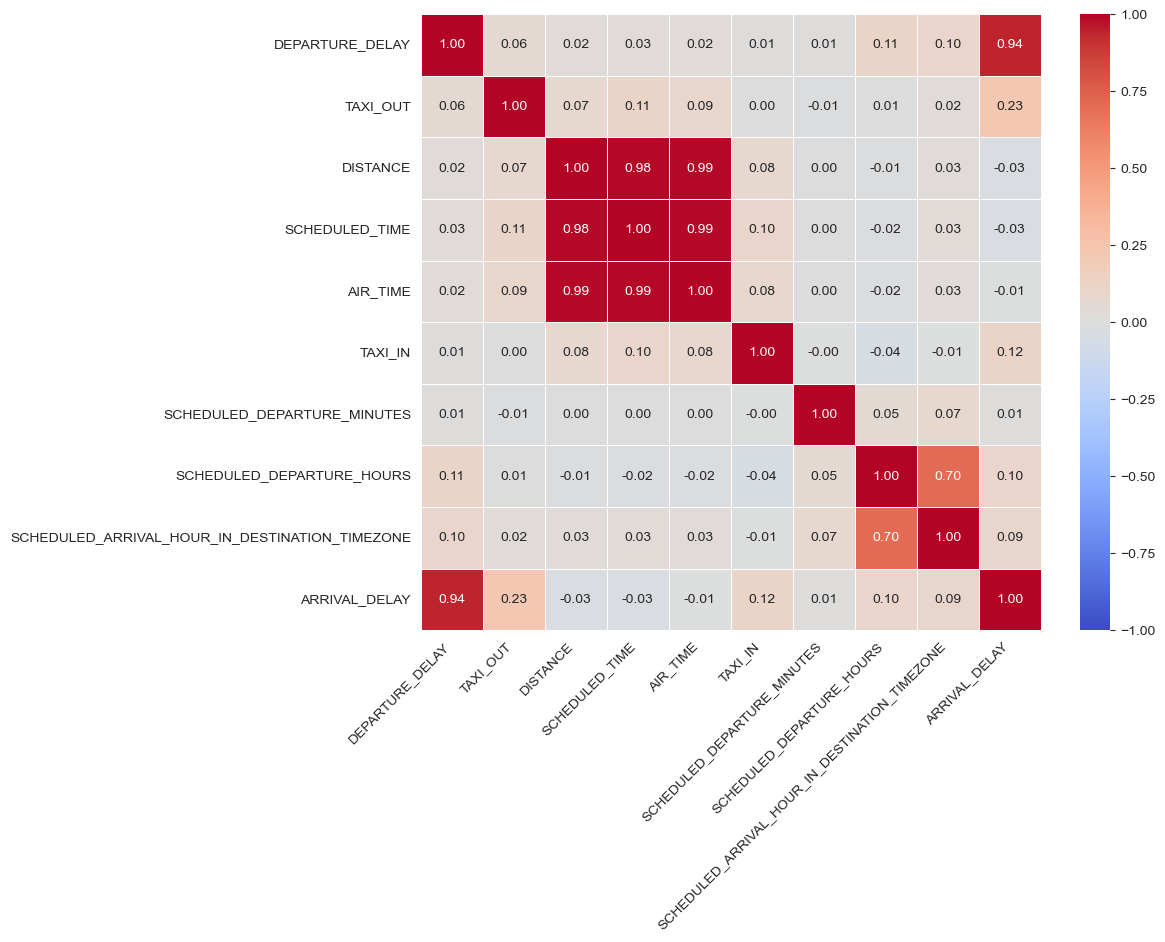

In [21]:
landed_corr = landed_df[column_EDA].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(landed_corr,
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            vmin=-1,
            vmax=1)

plt.xticks(rotation=45, ha="right")

plt.show()

Looking at the correlation of these features:
- Taxi In has no correlation with Taxi Out.
- Distance, Scheduled Time, and Air Time, are highly correlated.
- Arrival Delay is the column most correlated to Departure Delay.
- It is followed by Taxi Out, then Taxi In, and then the
- Scheduled Departure Hour is also somewhat correlated to Arrival Delay, which aligns with my analysis earlier in the Notebook.
- There is a minute negative correlation between the Scheduled Time of a flight and the Arrival Delay.
- This is surprising given that Scheduled Time is positively correlated with Taxi In, Taxi Out, and Departure Delay.

# Step 2: Comparative Analysis
Next, I will try and explain the variation in the data by exploring categorical data such as airlines and airports.

### Analysis of States and Population
I will start with some data engineering to accumulate extra information for each US State.

In [22]:
# Read in populations, in 2015, of each state.
populations_df = (pd.read_csv("data/nst-est2019-popchg2010_2019.csv",
                             usecols=["NAME", "POPESTIMATE2015"])
                  .rename({"NAME":"state_name", "POPESTIMATE2015":"population"}, axis=1))
populations_df.head(10)

,state_name,population
0,United States,320635163
1,Northeast Region,56034684
2,Midwest Region,67860583
3,South Region,120997341
4,West Region,75742555
5,Alabama,4852347
6,Alaska,737498
7,Arizona,6829676
8,Arkansas,2978048
9,California,38918045


In [23]:
# My original dataset doesn't have the names of the states, but has 2 letter state codes instead, so I will read in another csv file with the 2 letter state codes to create a common column for merging.
state_codes_df = pd.read_csv("data/US-2-letter-state-code.csv")
state_codes_df.head(10)

,state_name,state_code
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District of Columbia,DC


In [24]:
# Merge state codes and population
populations_df = pd.merge(state_codes_df, populations_df, on="state_name").rename({"state_code":"STATE"}, axis=1)

# Gather airport info from landed_df
airport_info_df = (pd.merge(landed_df.groupby("ORIGIN_AIRPORT")[["DEPARTURE_DELAY", "ARRIVAL_DELAY", "DISTANCE"]].mean(),
                            landed_df["ORIGIN_AIRPORT"].value_counts(), on="ORIGIN_AIRPORT")
                   .reset_index()
                   .rename({"ORIGIN_AIRPORT":"IATA_CODE"}, axis=1))

# Gather airport info from airports_df.
airport_info_df = pd.merge(airport_info_df,
                           airports_df[["IATA_CODE", "AIRPORT", "CITY", "STATE", "LONGITUDE"]], on="IATA_CODE")

# Merge populations to airports_info_df.
airport_info_df = pd.merge(airport_info_df, populations_df, on="STATE")


In [25]:
airport_info_df.head()

,IATA_CODE,DEPARTURE_DELAY,ARRIVAL_DELAY,DISTANCE,count,AIRPORT,CITY,STATE,LONGITUDE,state_name,population
0,ABE,8.753447,6.280211,597.584347,2466,Lehigh Valley International Airport,Allentown,PA,-75.44040,Pennsylvania,12784826
1,AVP,8.786509,6.529207,552.230181,1438,Wilkes-Barre/Scranton International Airport,Wilkes-Barre/Scranton,PA,-75.72427,Pennsylvania,12784826
2,ERI,7.007843,7.705882,368.023529,765,Erie International Airport,Erie,PA,-80.17622,Pennsylvania,12784826
3,LBE,9.561029,7.203676,928.944853,1360,Arnold Palmer Regional Airport,Latrobe,PA,-79.40480,Pennsylvania,12784826
4,MDT,7.688984,1.651216,566.301574,3495,Harrisburg International Airport,Harrisburg,PA,-76.76340,Pennsylvania,12784826


In [26]:
# Merging landed_df with airport_info_df to add information for both Origin and Destination airports
landed_df = pd.merge(landed_df,
                     airport_info_df[["IATA_CODE", "CITY", "STATE", "LONGITUDE"]]
                     .rename({"IATA_CODE":"ORIGIN_AIRPORT", "CITY":"ORIGIN_CITY", "STATE":"ORIGIN_STATE", "LONGITUDE":"ORIGIN_LONGITUDE"}, axis=1),
                     on="ORIGIN_AIRPORT")

landed_df = pd.merge(landed_df,
                     airport_info_df[["IATA_CODE", "CITY", "STATE", "LONGITUDE"]]
                     .rename({"IATA_CODE":"DESTINATION_AIRPORT", "CITY":"DESTINATION_CITY", "STATE":"DESTINATION_STATE", "LONGITUDE":"DESTINATION_LONGITUDE"}, axis=1),
                     on="DESTINATION_AIRPORT")

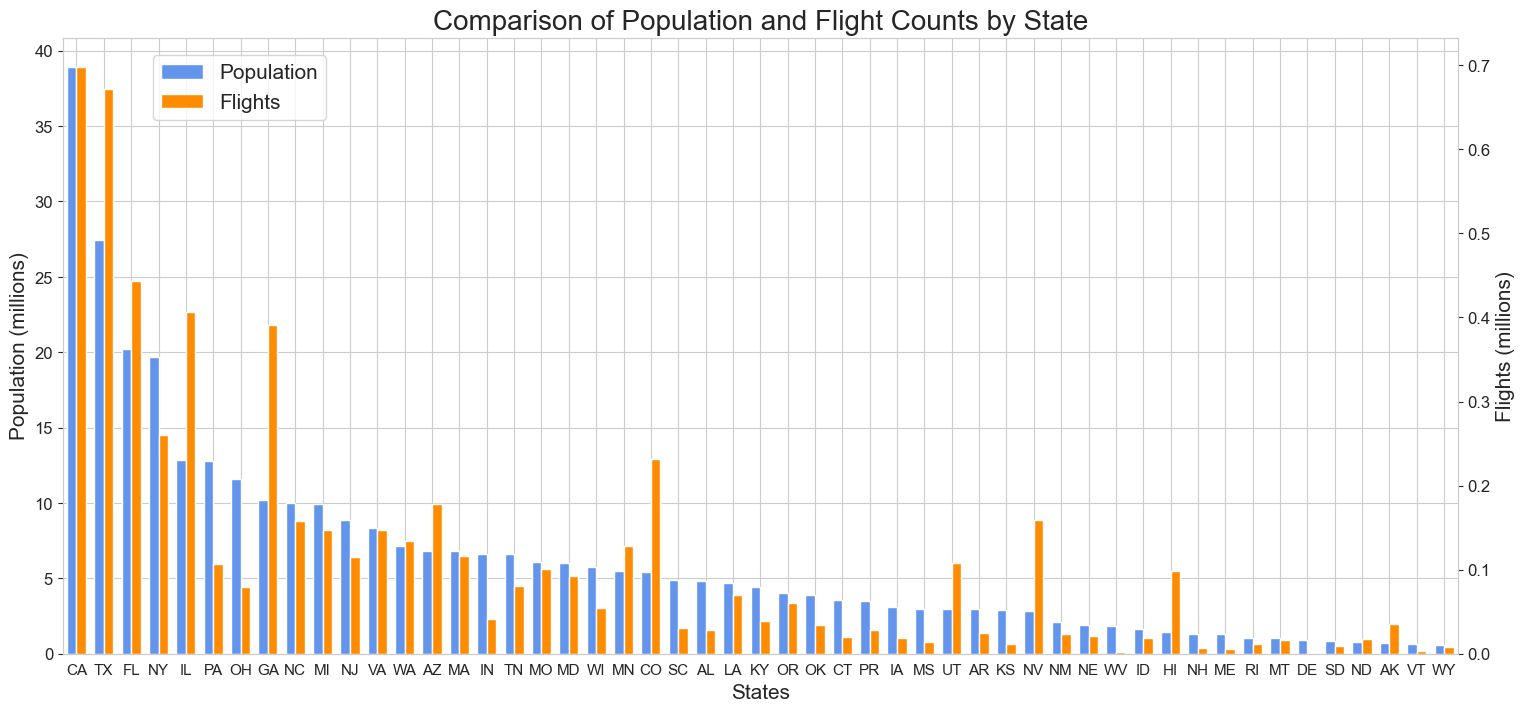

In [137]:
#
flights_population_df = (airport_info_df.groupby("STATE")
                         .agg({"count":"sum",
                               "DISTANCE":"mean",
                               "population":"mean"})
                         .reset_index()
                         .sort_values(by="population", ascending=False))

# Selecting the data.
state_names = flights_population_df["STATE"].to_list()
population = (flights_population_df["population"]/1000000).to_list()
flights = (flights_population_df["count"]/1000000).to_list()

x_positions = np.arange(len(state_names))
width = 0.35

# Creating the population bar.
fig, ax1 = plt.subplots(figsize=(18,8))
population_bar = ax1.bar(x_positions - width/2, population,
               width=width,
               color="cornflowerblue")

# Formatting the x-axis.
ax1.set_xlabel("States", size=15)
ax1.tick_params(axis="x", labelsize=11)
ax1.set_xlim([-0.5, len(state_names) - 0.5])
plt.xticks(x_positions, state_names)

# Formatting the population y-axis.
ax1.set_ylabel("Population (millions)", size=15)
ax1.tick_params(axis="y", labelsize=12)

# Creating the flights bar.
ax2 = ax1.twinx()
flights_bar = ax2.bar(x_positions + width/2, flights,
               width=width,
               color="darkorange")

# Formatting the flights y-axis.
ax2.set_ylabel("Flights (millions)", size=15)
ax2.tick_params(axis="y", labelsize=12)
ax2.grid(False)

plt.title("Comparison of Population and Flight Counts by State", fontsize=20)
fig.legend([population_bar, flights_bar],
           ["Population", "Flights"],
           loc=(0.1,0.83),
           fontsize=15)

plt.show()

Flights roughly correlate to population, with certain states, (that may have hub airports) having disproportionately more flights.

The "Hub and Spoke Model" is a system used by airlines to have lots of flights going in and out of a single airport (such as Delta and Atlanta ATL).  This means that instead of having 1 flight connecting 2 less busy airports, there will be 2 flights ("Spokes") going via the "Hub" airport.

It would appear that these hubs could be in Texas, Illinois, Georgia, Colorado, Utah, Arizona, and Nevada, because of the high number of flights per capita.

Certain states, such as New York, may have a disproportionate amount of international fights, which are not counted in this data.

There will be states with fewer flights per capita such as Indiana, who may go to the neighbouring Illinois for their flights.

In [28]:
(flights_population_df.set_index("STATE")["count"] / flights_population_df.set_index("STATE")["population"]).nlargest(10).rename("Flights per Person")

STATE
HI    0.069331
NV    0.055510
AK    0.047993
CO    0.042443
GA    0.038385
UT    0.036302
IL    0.031574
AZ    0.026129
TX    0.024477
MN    0.023469
Name: Flights per Person, dtype: float64

We can see that the states with the most flights per person include Hawaii and Alaska which are both not contiguous with the other 48 states and so it is expected that they would have more flights.

- Colorado (United, Frontier)
- Georgia (Delta)
- Illinois (American, United)
- Texas (American, United)
All contain major hubs whilst
- Utah (Delta)
- Arizona (American)
- Nevada (Spirit)
all contain smaller hubs.

6 of the 7 states have 1 city that is much larger than any other and so could have most of its flights coming out of 1 city making it a natural location for a hub.

The only other state in the top 10 is North Dakota, which has a smaller sample size than every other state, and so may be affected easier by smaller factors, such as the states near it not having a major airport.  We can see the lack of airports apparent in the 10 states with the least flights per person.

What is also of note is that 8 of the 10 states are in the Western part of the United States.  This could be because the Western USA is more sparsely populated and so flying (rather than driving) becomes necessary more often.

In [29]:
(flights_population_df.set_index("STATE")["count"] / flights_population_df.set_index("STATE")["population"]).nsmallest(10).rename("Flights per Person")

STATE
DE    0.000101
WV    0.001378
KS    0.003982
ME    0.004061
MS    0.004665
NH    0.005003
VT    0.005165
CT    0.005598
IA    0.005819
AL    0.005840
Name: Flights per Person, dtype: float64

The states with the least flights per person are disproportionately in the North East:
- Deleware
- Maine
- New Hampshire
- Vermont
- Conneticut
And include the Deep South states of Alabama and Mississippi.

A reason for these 10 states having the lesat flights per person could be the lack a major city that could accommodate a major airport causing passengers to go to nearby states.

There could also be cultural values in play, such as those living in New England and the Deep South preferring to drive than to fly, or just being less likely to travel overall.

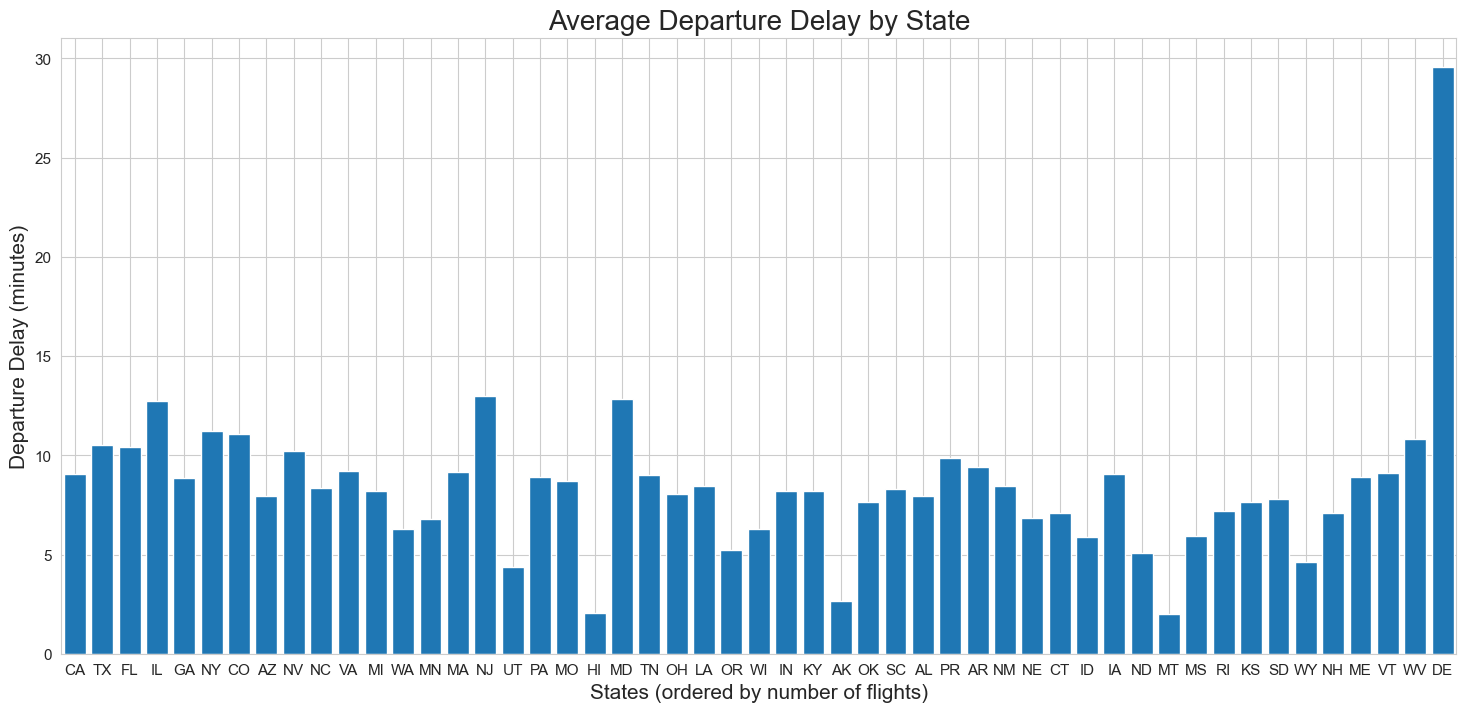

In [30]:
state_delay = (landed_df.groupby("ORIGIN_STATE")
               .agg({"DEPARTURE_DELAY":"mean", "TAXI_IN":"count"})
               .sort_values(by="TAXI_IN", ascending=False))

plt.figure(figsize=(18,8))
plt.bar(state_delay.index, state_delay["DEPARTURE_DELAY"])

plt.title("Average Departure Delay by State", fontsize=20)
plt.xlabel("States (ordered by number of flights)", size=15)
plt.xticks(x_positions, state_delay.index, size=11)
plt.ylabel("Departure Delay (minutes)", size=15)
plt.yticks(size=11)

plt.xlim([-0.5, len(state_delay.index) - 0.5])

plt.show()

In [31]:
print(f"Delaware's incredibly high Average Departure Delay can be explained by its small sample size: Only {state_delay.loc['DE', 'TAXI_IN']} flights.")

Delaware's incredibly high Average Departure Delay can be explained by its small sample size: Only 95 flights.


Hawaii, Montana, and Alaska, have the lowest average Departure Delay.

Excluding Delaware, Illinois, New Jersey, and Maryland have the highest average Departure Delay.

### Analysis of Airlines

In [92]:
# Grouping by Airline to extract statistics.
airlines_flights_df = landed_df.groupby("AIRLINE").agg({"ARRIVAL_DELAY":["mean", "std", "median", lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
                                                        "DISTANCE":"mean",
                                                        "SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE":"mean",
                                                        "SCHEDULED_DEPARTURE":"mean",
                                                        "TAXI_OUT":"count"})

# Remove the multi-index.
airlines_flights_df.columns = [f"{col[0]}_{col[1].upper()}" if col[0] == "ARRIVAL_DELAY" else col[0] for col in airlines_flights_df.columns]

# Rename the columns
airlines_flights_df = airlines_flights_df.rename(columns={"TAXI_OUT":"NUMBER_OF_FLIGHTS",
                                                          "ARRIVAL_DELAY_<LAMBDA_0>":"ARRIVAL_DELAY_25th_PERCENTILE",
                                                          "ARRIVAL_DELAY_<LAMBDA_1>":"ARRIVAL_DELAY_75th_PERCENTILE"})

# Include extra information about the airline
airlines_flights_df = (pd.merge(airlines_flights_df,
                               airlines_df.rename({"IATA_CODE":"AIRLINE", "AIRLINE":"AIRLINE_NAME"}, axis=1),
                               on="AIRLINE")
                       .set_index("AIRLINE_NAME")
                       .sort_values(by="ARRIVAL_DELAY_MEAN", ascending=False))

In [93]:
airlines_flights_df

,AIRLINE,ARRIVAL_DELAY_MEAN,ARRIVAL_DELAY_STD,ARRIVAL_DELAY_MEDIAN,ARRIVAL_DELAY_25th_PERCENTILE,ARRIVAL_DELAY_75th_PERCENTILE,DISTANCE,SCHEDULED_ARRIVAL_HOUR_IN_DESTINATION_TIMEZONE,SCHEDULED_DEPARTURE,NUMBER_OF_FLIGHTS
AIRLINE_NAME,,,,,,,,,,
Spirit Air Lines,NK,14.501331,45.896008,0.0,-10.0,20.0,985.109695,14.460410,2015-07-08 15:54:18.742700544,114563
Frontier Airlines Inc.,F9,12.504706,51.561753,-1.0,-11.0,16.0,967.156022,14.811733,2015-07-09 08:23:39.598401536,90090
JetBlue Airways,B6,6.718808,41.448376,-5.0,-14.0,12.0,1070.752434,14.420670,2015-07-05 04:55:08.153418240,259474
Atlantic Southeast Airlines,EV,6.585379,40.682366,-4.0,-12.0,9.0,461.701851,14.499836,2015-06-27 23:41:59.018480128,554752
American Eagle Airlines Inc.,MQ,6.457873,44.458112,-6.0,-15.0,10.0,422.661417,14.358623,2015-06-22 11:14:39.861473280,278791
Skywest Airlines Inc.,OO,5.845652,39.257694,-4.0,-12.0,8.0,497.727302,14.502824,2015-07-02 10:40:37.450304768,576814
United Air Lines Inc.,UA,5.428894,44.018726,-6.0,-16.0,9.0,1267.330033,14.535902,2015-07-06 06:11:17.684184320,506137
Virgin America,VX,4.737706,35.621579,-3.0,-12.0,9.0,1404.377531,15.447329,2015-07-08 18:04:37.784090880,61248
Southwest Airlines Co.,WN,4.374964,32.774001,-4.0,-12.0,8.0,741.754653,14.662814,2015-07-04 01:34:56.160907520,1242403


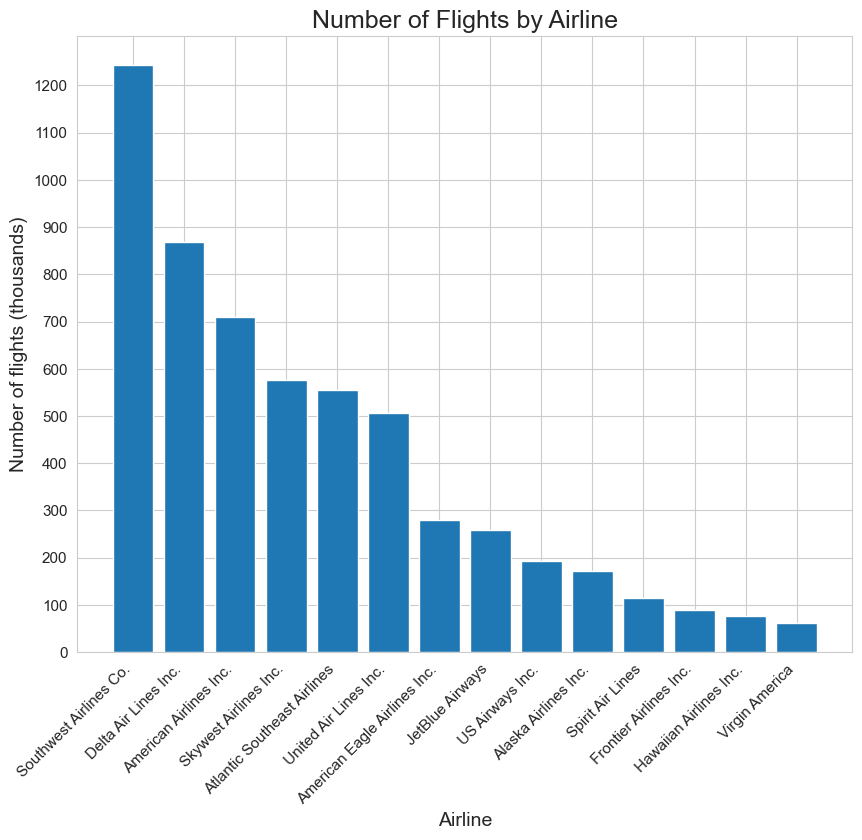

In [94]:
plt.figure(figsize=(10,8))
plt.bar(airlines_flights_df.sort_values(by="NUMBER_OF_FLIGHTS", ascending=False).index, airlines_flights_df.sort_values(by="NUMBER_OF_FLIGHTS", ascending=False)["NUMBER_OF_FLIGHTS"] / 1000)

plt.title("Number of Flights by Airline", size=18)
plt.xlabel("Airline", size=14)
plt.xticks(rotation=45, ha="right", size=11)
plt.ylabel("Number of flights (thousands)", size=14)
plt.yticks(range(0,1300,100), size=11)

plt.show()

Southwest has the most flights by far, with over 1 million, whilst Virgin, Hawaiian, and Frontier all had less than 100,000

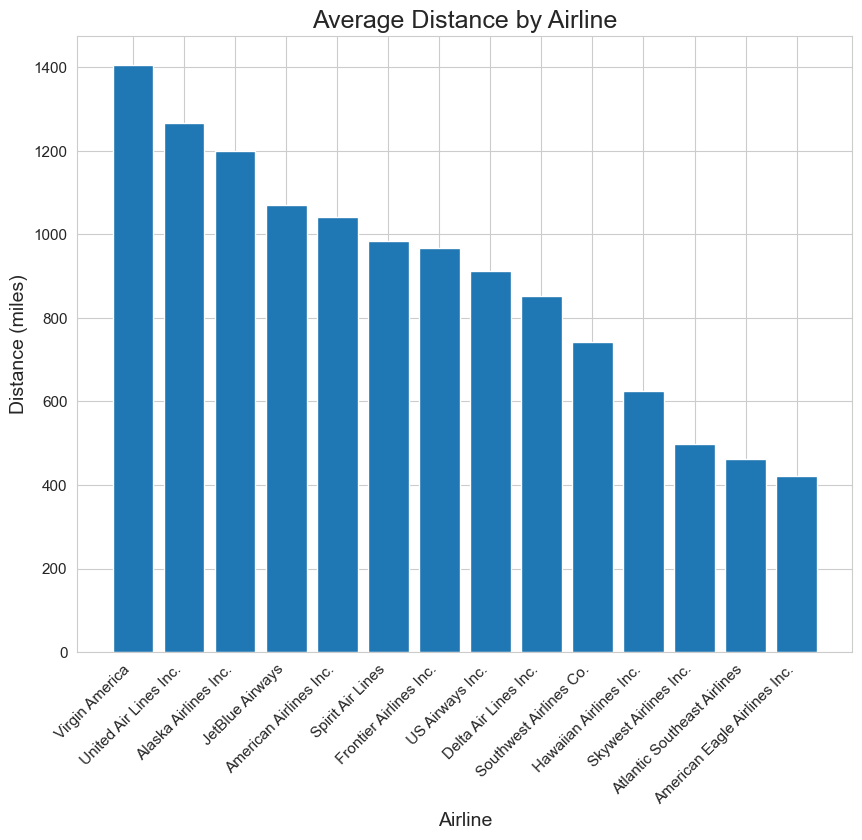

In [95]:
plt.figure(figsize=(10,8))
plt.bar(airlines_flights_df.sort_values(by="DISTANCE", ascending=False).index, airlines_flights_df.sort_values(by="DISTANCE", ascending=False)["DISTANCE"])

plt.title("Average Distance by Airline", size=18)
plt.xlabel("Airline", size=14)
plt.xticks(rotation=45, ha="right", size=11)
plt.ylabel("Distance (miles)", size=14)
plt.yticks(size=11)

plt.show()


Virgin America, despite having the least flights, has the longest average distance of its flights.

Southwest, which has the most flights by quite a distance is in the bottom half of average distance.

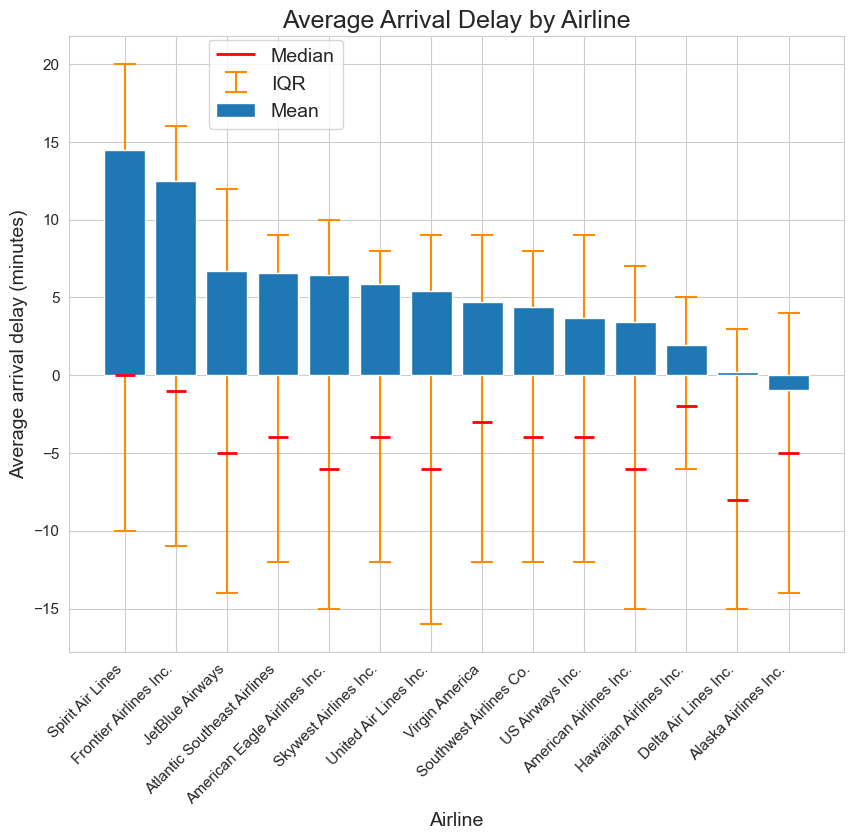

In [116]:
plt.figure(figsize=(10,8))

# Creating an error bar for the inter-quartile range.
plt.errorbar(airlines_flights_df.index, airlines_flights_df["ARRIVAL_DELAY_MEAN"],
             yerr=[airlines_flights_df["ARRIVAL_DELAY_MEAN"] - airlines_flights_df["ARRIVAL_DELAY_25th_PERCENTILE"], airlines_flights_df["ARRIVAL_DELAY_75th_PERCENTILE"] - airlines_flights_df["ARRIVAL_DELAY_MEAN"]],
             capsize=8,
             capthick=1.5,
             fmt="none",
             color="darkorange",
             label="IQR",
             zorder=1)

# Plotting the median.
plt.hlines(airlines_flights_df["ARRIVAL_DELAY_MEDIAN"],
           np.arange(len(airlines_flights_df.index)) - 0.2,
           np.arange(len(airlines_flights_df.index)) + 0.2,
           color="red",
           linewidth=2,
           label="Median")

# Plotting the mean.
plt.bar(airlines_flights_df.index, airlines_flights_df["ARRIVAL_DELAY_MEAN"], label="Mean")

plt.title("Average Arrival Delay by Airline", size=18)
plt.xlabel("Airline", size=14)
plt.xticks(rotation=45, ha="right", size=11)
plt.ylabel("Average arrival delay (minutes)", size=14)
plt.yticks(size=11)
plt.legend(loc=(0.18,0.85), fontsize=14)

plt.show()

Spirit and Frontier have the longest verage Arrival Delay, each over 10 minutes long, whilst Alaska and Delta, on average, arrive without delay.

Hawaiian has the narrowest interquartile range (IQR), the 3rd lowest mean, but the 3rd highest median.

For all airlines, the mean is skewed towards the upper end of the IQR, and it is most likely skewed by a small number of very large Arrival Delays.

The median for all airlines is either 0, or below 0.  Delta has the lowest median Arrival Delay.

We can also see that by looking at the mean, and the IQR, there isn't a large difference in the variation of arrival delays for most airlines:<br>(JetBlue, Atlantic Southeast, American Eagle, Skywest, United, Virgin, Southwest, US Airways &, American)

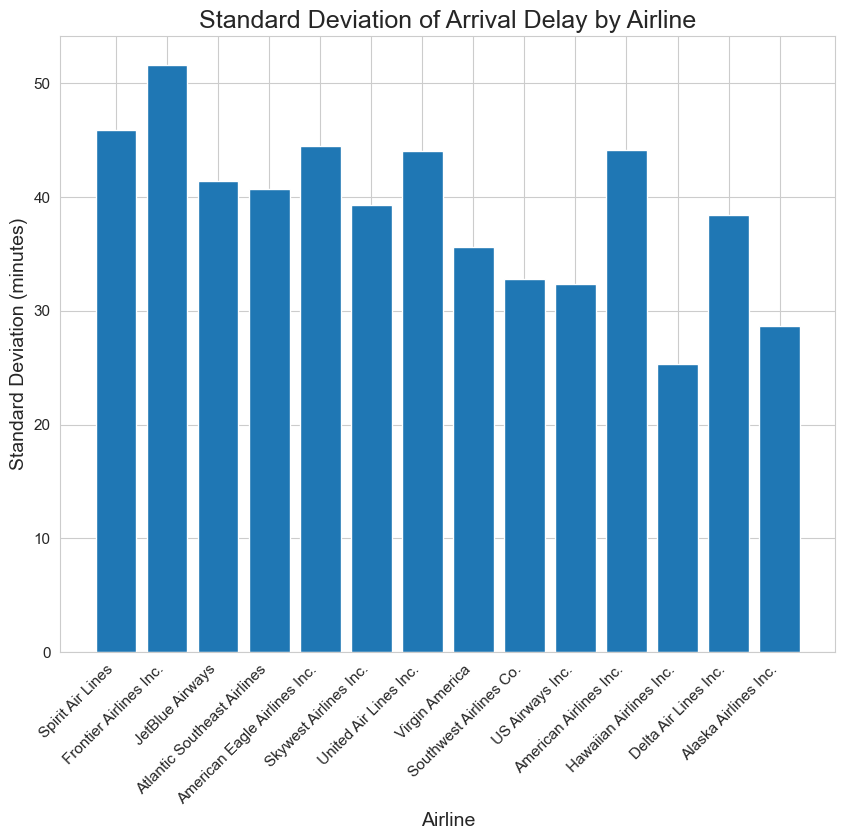

In [97]:
plt.figure(figsize=(10,8))
plt.bar(airlines_flights_df.index, airlines_flights_df["ARRIVAL_DELAY_STD"])

plt.title("Standard Deviation of Arrival Delay by Airline", size=18)
plt.xlabel("Airline", size=14)
plt.xticks(rotation=45, ha="right", size=11)
plt.ylabel("Standard Deviation (minutes)", size=14)
plt.yticks(size=11)

plt.show()

We can see that the airlines, which are ordered from left to right by mean Arrival Delay, clearly have a correlation between the standard deviation of their Arrival Delays and their mean Arrival Delay.

Simply, the longer an airlines mean Arrival Delay is, the larger the variation across their Arrival Delays will be.

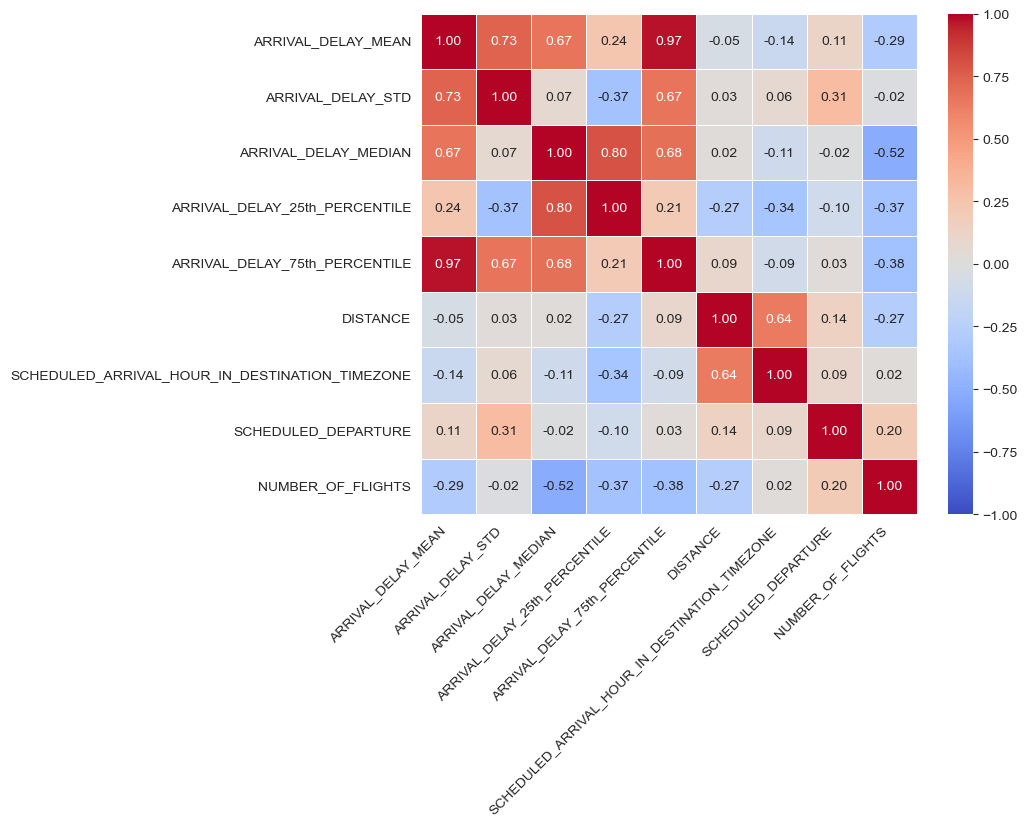

In [98]:
plt.figure(figsize=(8, 6.5))
sns.heatmap(airlines_flights_df.drop("AIRLINE", axis=1).corr(),
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            vmin=-1,
            vmax=1)

plt.xticks(rotation=45, ha="right")
plt.show()

Looking at the r values, we can see that when the flights are grouped by what airlines flew them:
- Airlines that run longer flights are more likely to have their flights arrive later in the day.
- Airlines that run fewer flights have a lower mean Arrival Delay, and shorter mean flights.
- Airlines that have a later average Scheduled Departure, the larger the variation is in its arrival delay.

### Analysis of Airports

In [39]:
# Because of the apparent East-West differences in among my analysis of flights per state, I have included the Origin Airport's Longitude in my analysis of airports.
airports_flights_df = (landed_df.groupby(["ORIGIN_AIRPORT"]).agg({"DEPARTURE_DELAY":"mean",
                                                                 "DISTANCE":"mean",
                                                                 "SCHEDULED_DEPARTURE":"mean",
                                                                 "TAXI_OUT":"mean",
                                                                 "ORIGIN_LONGITUDE":"mean",
                                                                 "TAXI_IN":"count"})
                       .rename({"TAXI_IN":"NUMBER_OF_FLIGHTS"}, axis=1)
                       .reset_index())

# Include extra information about the origin airport.
# Because the Departure Delay is so highly correlated with the Arrival Delay, I will mainly be focusing on Origin Airports rather than Destination Airports.
airports_flights_df = (pd.merge(airports_flights_df,
                               airports_df[["IATA_CODE", "AIRPORT", "STATE"]]
                                .rename({"IATA_CODE":"ORIGIN_AIRPORT", "AIRPORT":"FULL_NAME"}, axis=1),
                                on="ORIGIN_AIRPORT")
                       .reset_index()
                       .set_index(["ORIGIN_AIRPORT", "FULL_NAME", "STATE"])
                       .drop("index", axis=1))

In [40]:
(airports_flights_df.loc[airports_flights_df["DEPARTURE_DELAY"] < 0.,
["DEPARTURE_DELAY", "DISTANCE", "NUMBER_OF_FLIGHTS"]]
 .sort_values(by="DEPARTURE_DELAY"))

,,,DEPARTURE_DELAY,DISTANCE,NUMBER_OF_FLIGHTS
ORIGIN_AIRPORT,FULL_NAME,STATE,,,
YAK,Yakutat Airport,AK,-6.265449,205.960674,712
CNY,Canyonlands Field,UT,-6.058537,184.000000,205
EKO,Elko Regional Airport,NV,-3.933333,200.000000,570
VEL,Valdez Airport,UT,-3.740000,132.000000,200
CDV,Merle K. (Mudhole) Smith Airport,AK,-3.460784,186.574230,714
LWS,Lewiston-Nez Perce County Airport,ID,-3.126365,461.000000,641
PIH,Pocatello Regional Airport,ID,-1.755994,150.000000,709
SCC,Deadhorse Airport (Prudhoe Bay Airport),AK,-1.097098,297.947545,896
ITO,Hilo International Airport,HI,-0.974400,305.156658,6211


Only 11 aiports have their flights leave early, on average.

All but a single aiport on this list has less than 1,000 flights, the single exception being Hilo International with 6,211 flights.

In [41]:
(airports_flights_df.loc[airports_flights_df["NUMBER_OF_FLIGHTS"] > 10000,
["DEPARTURE_DELAY", "DISTANCE", "NUMBER_OF_FLIGHTS", "ORIGIN_LONGITUDE"]]
 .sort_values(by="DEPARTURE_DELAY", ascending=False))

,,,DEPARTURE_DELAY,DISTANCE,NUMBER_OF_FLIGHTS,ORIGIN_LONGITUDE
ORIGIN_AIRPORT,FULL_NAME,STATE,,,,
ORD,Chicago O'Hare International Airport,IL,13.193269,721.320041,304074,-87.90446
EWR,Newark Liberty International Airport,NJ,13.108064,1092.446772,107612,-74.16866
BWI,Baltimore-Washington International Airport,MD,12.813128,767.153824,92320,-76.66820
LGA,LaGuardia Airport (Marine Air Terminal),NY,12.702065,802.492317,103281,-73.87261
IAD,Washington Dulles International Airport,VA,12.080897,1303.835823,36491,-77.45581
...,...,...,...,...,...,...
OGG,Kahului Airport,HI,3.383563,1245.529092,22291,-156.43046
ANC,Ted Stevens Anchorage International Airport,AK,3.165112,1396.551487,17043,-149.99619
HNL,Honolulu International Airport,HI,2.394151,1241.747356,46231,-157.92241


Of airports with over 10,000 flights a day, the 10 with the biggest average Departure Delay are all in major cities and include both major airports in Chicago.


In [42]:
(airports_flights_df.loc[airports_flights_df["NUMBER_OF_FLIGHTS"] > 10000,
["DEPARTURE_DELAY", "DISTANCE", "NUMBER_OF_FLIGHTS", "ORIGIN_LONGITUDE"]]
 .sort_values(by="DEPARTURE_DELAY"))

,,,DEPARTURE_DELAY,DISTANCE,NUMBER_OF_FLIGHTS,ORIGIN_LONGITUDE
ORIGIN_AIRPORT,FULL_NAME,STATE,,,,
LIH,Lihue Airport,HI,0.497668,918.384162,11365,-159.33896
KOA,Kona International Airport at Keahole,HI,1.256365,983.757863,12018,-156.04563
HNL,Honolulu International Airport,HI,2.394151,1241.747356,46231,-157.92241
ANC,Ted Stevens Anchorage International Airport,AK,3.165112,1396.551487,17043,-149.99619
OGG,Kahului Airport,HI,3.383563,1245.529092,22291,-156.43046
...,...,...,...,...,...,...
IAD,Washington Dulles International Airport,VA,12.080897,1303.835823,36491,-77.45581
LGA,LaGuardia Airport (Marine Air Terminal),NY,12.702065,802.492317,103281,-73.87261
BWI,Baltimore-Washington International Airport,MD,12.813128,767.153824,92320,-76.66820


Of airports with over 10,000 flights a day, the 3 with the smallest average Departure Delay are from Hawaii, and all are in the Western USA.

Just looking at the 10 most and least delayed airports, it does not appear that the mean Distance of the flights from those airports has an effect on how much the flights from an airport are delayed.

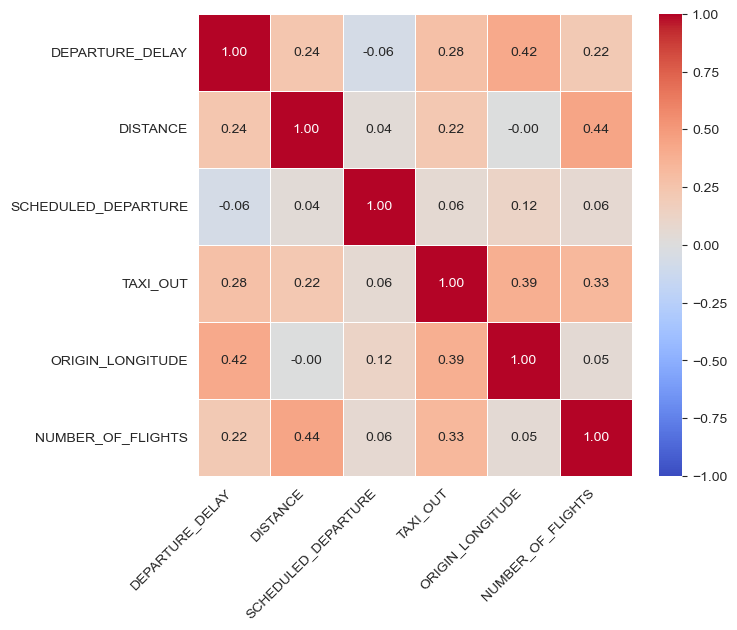

In [43]:
plt.figure(figsize=(7, 6))
sns.heatmap(airports_flights_df.corr(),
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5,
            vmin=-1,
            vmax=1)

plt.xticks(rotation=45, ha="right")

plt.show()

The r value, when  of 0.28 between Taxi Out and Departure Delay slightly higher than the correlation of the dataframe without grouping, it was

When flights are grouped by airports we can see several other notable correlations:
- The r value, of 0.28, between Taxi Out and Departure Delay higher than the correlation without grouping (0.06).
- The further East an airport is, the longer it's Departure Delay and Taxi Out.
- Airports with more flights tend to have flights with a longer average Distance.
- They also tend to have longer Departure Delays.
- Airports with longer Taxi Outs tend to have longer Departure Delays as well.

There is no correlation between the Longitude of the Origin Airport and the average Distance of flights from that airport when I would expect flights in the Western USA to have longer average flights than in the Eastern USA.

### Airport - Airline Combinations
Grouping flights from each airline with their origin airport.

My assumption for this grouping is that there will be crews from each airline that are permanently at each airport which might be able to explain some of the variation in Departure Delay.

In [56]:
airlines_airports_flights_df = (landed_df.groupby(["ORIGIN_AIRPORT", "AIRLINE"]).agg({"DEPARTURE_DELAY":"mean",
                                                                                     "DISTANCE":"mean",
                                                                                     "SCHEDULED_DEPARTURE":"mean",
                                                                                     "TAXI_OUT":"mean",
                                                                                     "ORIGIN_LONGITUDE":"mean",
                                                                                     "TAXI_IN":"count"})
                                .rename({"TAXI_IN":"NUMBER_OF_FLIGHTS"}, axis=1)
                                .dropna())

# Remove all combinations with less than 1,000 departing flights.
airlines_airports_flights_df = airlines_airports_flights_df[airlines_airports_flights_df["NUMBER_OF_FLIGHTS"] > 1000]

# Include extra information about the airlines.
airlines_airports_flights_df = (pd.merge(airlines_airports_flights_df.reset_index(),
                                        airlines_df.rename({"IATA_CODE":"AIRLINE", "AIRLINE":"AIRLINE_NAME"}, axis=1),
                                        on="AIRLINE")
                                .drop("AIRLINE", axis=1))

# Include extra information about the origin airports.
airlines_airports_flights_df = (pd.merge(airlines_airports_flights_df,
                                        airports_df[["IATA_CODE", "AIRPORT", "STATE"]]
                                        .rename({"IATA_CODE":"ORIGIN_AIRPORT", "AIRPORT":"AIRPORT_NAME"}, axis=1),
                                        on="ORIGIN_AIRPORT")
                                .set_index(["ORIGIN_AIRPORT", "AIRPORT_NAME", "STATE", "AIRLINE_NAME"]))

In [58]:
airlines_airports_flights_df["NUMBER_OF_FLIGHTS"].nlargest(10)

ORIGIN_AIRPORT  AIRPORT_NAME                                      STATE  AIRLINE_NAME                
ATL             Hartsfield-Jackson Atlanta International Airport  GA     Delta Air Lines Inc.            240646
DFW             Dallas/Fort Worth International Airport           TX     American Airlines Inc.          143203
MDW             Chicago Midway International Airport              IL     Southwest Airlines Co.           81447
LAS             McCarran International Airport                    NV     Southwest Airlines Co.           74314
BWI             Baltimore-Washington International Airport        MD     Southwest Airlines Co.           68481
ORD             Chicago O'Hare International Airport              IL     American Eagle Airlines Inc.     65864
                                                                         United Air Lines Inc.            64427
IAH             George Bush Intercontinental Airport              TX     Atlantic Southeast Airlines      61744
MS

The most common airport-airline combination is Delta with ATL with around 240,000 flights followed by American with DFW with around 140,000 flights.

Southwest Airlines has 3 different airports in the top 5, Chicago MDW, Las Vegas LAS, and Baltimore BWI.

Chicago ORD, and Atlanta ATL are the only airports to feature twice in the top 10 (which means that both airports act as a major hub for 2 different airlines).

In [60]:
airlines_airports_flights_df[["DEPARTURE_DELAY", "NUMBER_OF_FLIGHTS"]].sort_values(by="DEPARTURE_DELAY", ascending=False)

,,,,DEPARTURE_DELAY,NUMBER_OF_FLIGHTS
ORIGIN_AIRPORT,AIRPORT_NAME,STATE,AIRLINE_NAME,,
ANC,Ted Stevens Anchorage International Airport,AK,United Air Lines Inc.,25.100094,1059
ATL,Hartsfield-Jackson Atlanta International Airport,GA,Spirit Air Lines,22.962153,4941
ORD,Chicago O'Hare International Airport,IL,Spirit Air Lines,22.796582,10648
IAH,George Bush Intercontinental Airport,TX,Spirit Air Lines,22.329380,5565
LAX,Los Angeles International Airport,CA,Spirit Air Lines,21.216488,4767
...,...,...,...,...,...
SMF,Sacramento International Airport,CA,Alaska Airlines Inc.,-1.898789,2312
OAK,Oakland International Airport,CA,Alaska Airlines Inc.,-2.017812,2358
LIH,Lihue Airport,HI,Alaska Airlines Inc.,-2.310748,1284


The most delayed airline-airport combinations are from either Spirit or Frontier and all depart from major airports.

All apart from the most delayed, which is United from Anchorage ANC.

In [62]:
airlines_airports_flights_df[["DEPARTURE_DELAY", "NUMBER_OF_FLIGHTS"]].sort_values(by="DEPARTURE_DELAY")

,,,,DEPARTURE_DELAY,NUMBER_OF_FLIGHTS
ORIGIN_AIRPORT,AIRPORT_NAME,STATE,AIRLINE_NAME,,
BUR,Bob Hope Airport (Hollywood Burbank Airport),CA,Alaska Airlines Inc.,-3.498221,1124
SNA,John Wayne Airport (Orange County Airport),CA,Alaska Airlines Inc.,-2.882452,3573
LIH,Lihue Airport,HI,Alaska Airlines Inc.,-2.310748,1284
OAK,Oakland International Airport,CA,Alaska Airlines Inc.,-2.017812,2358
SMF,Sacramento International Airport,CA,Alaska Airlines Inc.,-1.898789,2312
...,...,...,...,...,...
LAX,Los Angeles International Airport,CA,Spirit Air Lines,21.216488,4767
IAH,George Bush Intercontinental Airport,TX,Spirit Air Lines,22.329380,5565
ORD,Chicago O'Hare International Airport,IL,Spirit Air Lines,22.796582,10648


9 out of 10 of the least delayed airline-airport combinations are Alaskan Airlines and all are based in the Western USA, although none in Alaska itself.

### Route - Airport Combinations

Grouping flights from each airline with both their Origin and Destination Airports.

In [75]:
airlines_both_airports_flights_df = (landed_df.groupby(["ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "AIRLINE"]).agg({"ARRIVAL_DELAY":"mean",
                                                                                                                  "SCHEDULED_DEPARTURE":"mean",
                                                                                                                  "TAXI_OUT":"mean",
                                                                                                                  "TAXI_IN":"count"})
                                     .rename({"TAXI_IN":"NUMBER_OF_FLIGHTS"}, axis=1)
                                     .dropna())

# Include extra information about the airline.
airlines_both_airports_flights_df = (pd.merge(airlines_both_airports_flights_df.reset_index(),
                                             airlines_df.rename({"IATA_CODE":"AIRLINE", "AIRLINE":"AIRLINE_NAME"}, axis=1),
                                             on="AIRLINE")
                                     .drop("AIRLINE", axis=1))

# Include extra information about the origin airport.
airlines_both_airports_flights_df = pd.merge(airlines_both_airports_flights_df,
                                             airports_df[["IATA_CODE", "AIRPORT", "STATE"]]
                                             .rename({"IATA_CODE":"ORIGIN_AIRPORT", "AIRPORT":"ORIGIN_AIRPORT_NAME", "STATE":"ORIGIN_STATE"}, axis=1),
                                             on="ORIGIN_AIRPORT")

# Include extra information about the destination airport.
airlines_both_airports_flights_df = (pd.merge(airlines_both_airports_flights_df,
                                             airports_df[["IATA_CODE", "AIRPORT", "STATE"]]
                                             .rename({"IATA_CODE":"DESTINATION_AIRPORT",
                                                      "AIRPORT":"DESTINATION_AIRPORT_NAME",
                                                      "STATE":"DESTINATION_STATE"}, axis=1),
                                             on="DESTINATION_AIRPORT")
                                     .set_index(["ORIGIN_AIRPORT_NAME", "DESTINATION_AIRPORT_NAME", "AIRLINE_NAME"]))

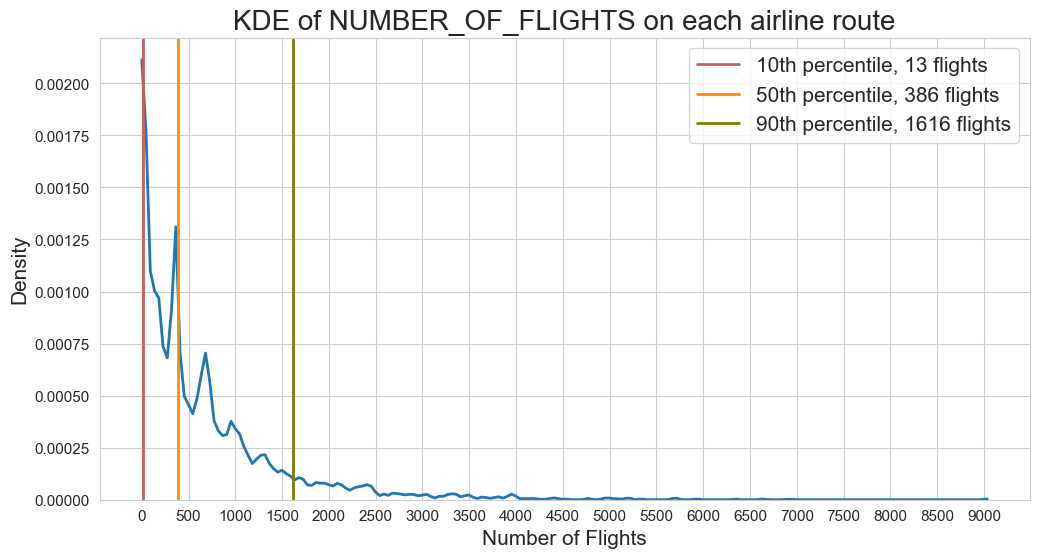

In [81]:
colours = ["indianred", "darkorange", "olive"]

plt.figure(figsize=(12,6))
sns.kdeplot(airlines_both_airports_flights_df["NUMBER_OF_FLIGHTS"],
            bw_adjust=0.2,
            cut=0,
            clip=(1, None),
            linewidth=2)


for i, p in enumerate(list(np.arange(0.1, 1, 0.4))):
    plt.axvline(x=airlines_both_airports_flights_df["NUMBER_OF_FLIGHTS"].quantile(q=p),
                color=colours[i],
                label=f"{p*100:.0f}th percentile, {airlines_both_airports_flights_df['NUMBER_OF_FLIGHTS'].quantile(q=p):.0f} flights",
                linewidth=2)

plt.title("KDE of NUMBER_OF_FLIGHTS on each airline route", size=20)
plt.xlabel("Number of Flights", size=15)
plt.xticks(range(0,9001,500), size=11)
plt.ylabel("Density", size=15)
plt.yticks(size=11)
plt.legend(fontsize=15)

plt.show()

The median number of flights is 386, which is just over 1 a day.

The 10th percentile is 13, just over 1 a month, and the 90th percentile is 1616, over 4 flights a day.

We can see spikes around 365 flights and 730 flights for airlines that run flights 1 or 2 times a day per route.

There is a long tail with a maximum of over 9,000.

In [86]:
airlines_both_airports_flights_df["NUMBER_OF_FLIGHTS"].value_counts().nlargest(10)

NUMBER_OF_FLIGHTS
1      247
2      112
3       93
5       85
4       78
364     50
363     49
362     43
360     42
6       40
Name: count, dtype: int64

The most common number of flights per airline route, are either very low, with 1 flight being the mode.

There are also 4 values that are just below 1 flight a day which is probably because these are daily flights that won't run on certain holidays.

In [87]:
# Filtering out the airline routes with less than 1 flight a day (with some leeway for American holidays).
airlines_both_airports_flights_df = airlines_both_airports_flights_df[airlines_both_airports_flights_df["NUMBER_OF_FLIGHTS"] > 355]

In [89]:
airlines_both_airports_flights_df[["ARRIVAL_DELAY", "NUMBER_OF_FLIGHTS"]].nlargest(10, "ARRIVAL_DELAY")

ARRIVAL_DELAY  \
ORIGIN_AIRPORT_NAME                              DESTINATION_AIRPORT_NAME                         AIRLINE_NAME                            
Chicago O'Hare International Airport             Denver International Airport                     Spirit Air Lines            33.476522   
Miami International Airport                      Denver International Airport                     Frontier Airlines Inc.      32.231111   
Los Angeles International Airport                Detroit Metropolitan Airport                     Spirit Air Lines            30.621170   
                                                 Chicago O'Hare International Airport             Spirit Air Lines            29.617852   
Chicago O'Hare International Airport             George Bush Intercontinental Airport             Spirit Air Lines            29.264803   
Hartsfield-Jackson Atlanta International Airport Detroit Metropolitan Airport                     Spirit Air Lines            29.065534   
Detroit Metropolitan Airport                     Hartsfield-Jackson Atlanta International Airport Spirit Air Lines            28.700730   
Sarasota-Bradenton International Airport         LaGuardia Airport (Marine Air Terminal)          JetBlue Airways             28.596639   
Tampa International Airport                      Philadelphia International Airport               Frontier Airlines Inc.      28.351801   
Dallas/Fort Worth International Airport          Kahului Airport                                  American Airlines Inc.      28.153846   

                                                                                                                          NUMBER_OF_FLIGHTS  
ORIGIN_AIRPORT_NAME                              DESTINATION_AIRPORT_NAME                         AIRLINE_NAME                               
Chicago O'Hare International Airport             Denver International Airport                     Spirit Air Lines                      575  
Miami International Airport                      Denver International Airport                     Frontier Airlines Inc.                450  
Los Angeles International Airport                Detroit Metropolitan Airport                     Spirit Air Lines                      359  
                                                 Chicago O'Hare International Airport             Spirit Air Lines                      717  
Chicago O'Hare International Airport             George Bush Intercontinental Airport             Spirit Air Lines                      608  
Hartsfield-Jackson Atlanta International Airport Detroit Metropolitan Airport                     Spirit Air Lines                      412  
Detroit Metropolitan Airport                     Hartsfield-Jackson Atlanta International Airport Spirit Air Lines                      411  
Sarasota-Bradenton International Airport         LaGuardia Airport (Marine Air Terminal)          JetBlue Airways                       357  
Tampa International Airport                      Philadelphia International Airport               Frontier Airlines Inc.                361  
Dallas/Fort Worth International Airport          Kahului Airport                                  American Airlines Inc.                533

6 of the top 7 most delayed airline routes are from Spirit.

The flights are also mainly between large hub airports: Chicago O'Hare, Denver, Dallas, Atlanta, Los Angeles etc.

The average Arrival Delay for all the airports in the top 10 is over 28 minutes.

In [91]:
airlines_both_airports_flights_df[["ARRIVAL_DELAY", "NUMBER_OF_FLIGHTS"]].nsmallest(10, "ARRIVAL_DELAY")

,,,ARRIVAL_DELAY,NUMBER_OF_FLIGHTS
ORIGIN_AIRPORT_NAME,DESTINATION_AIRPORT_NAME,AIRLINE_NAME,,
Seattle-Tacoma International Airport,Albuquerque International Sunport,Alaska Airlines Inc.,-15.789041,365
Phoenix Sky Harbor International Airport,Washington Dulles International Airport,United Air Lines Inc.,-15.356164,365
Fort Lauderdale-Hollywood International Airport,McCarran International Airport,Southwest Airlines Co.,-15.043956,364
Albuquerque International Sunport,Seattle-Tacoma International Airport,Alaska Airlines Inc.,-14.600551,363
Newark Liberty International Airport,Seattle-Tacoma International Airport,Alaska Airlines Inc.,-14.213483,712
Kahului Airport,Oakland International Airport,Alaska Airlines Inc.,-13.167582,364
Ronald Reagan Washington National Airport,Los Angeles International Airport,Alaska Airlines Inc.,-12.541209,364
Ted Stevens Anchorage International Airport,Los Angeles International Airport,Alaska Airlines Inc.,-12.252427,412
Louisville International Airport (Standiford Field),Phoenix Sky Harbor International Airport,Southwest Airlines Co.,-11.529086,361


8 of the airline routes with the shortest average Arrival Delays are from Alaska Airlines.

Like with the most delayed airline routes, none of the airlines operate more than 2 flights a day on average on the routes and many are around 1 flight a day.

# Conclusions
The main findings of this notebook include, but are not limited by:
- The 61% of flights arrive early but the mean Arrival Delay is around 4 minutes late because it is skewed by flights that are very delayed.

- Flights departing in the morning have a lower average Arrival Delay than those departing in the afternoon and evening.

- Flights that depart on the hour, have a Departure Delay of over a minute less than other flights.

- There are more flights in the summer months than in January and February but they have similar average Arrival Delays.

- 10% of flights are given multiple reasons for a delay.

- The feature that most correlates with Arrival Delay is Departure Delay.

- The state with the most flights departing from it is California, but Hawaii has the most flights per person.

- Virgin America, which runs the least flights, has the longest average flights.

- Alaska Airlines is the only airline whose mean Arrival Delay is negative.

- Flights originating from the Eastern USA have a higher average Departure Delay than those from the Western USA.

- The largest hub is Delta's Atlanta ATL.

- 10% of airline routes have over 4 flights a day.

### Implications:
These results can be used by airlines to identify airports where they have a disproportionately high arrival delay, or to identify rival airlines that have a more reliable service in order to understand their operations.

They could also be used by passengers to identify what airlines to avoid and the best times of the day to fly.

### Further Work:
Further analysis could be done to identify the time of year that particular routes could be impacted, such as routes in the South Eastern USA during hurricane season in autumn or route in the Northern USA during winter.

Further analysis could also be done to group airports by which city they are in to find, to compare the number of flights per city rather than just by state.

I will engage in further data engineering in the next notebook Flight_Predictions as part of the preprocessing for machine learning.

I will use the insights I have learnt from the exploratory data analysis in this notebook in order to inform my feature selection in Flight_Predictions.